In [ ]:
%%capture
import sys
!{sys.executable} -m pip install ucimlrepo
!{sys.executable} -m pip install seaborn

from ucimlrepo import fetch_ucirepo

import pandas as pd  
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import numpy as np
from itertools import product

print("Bibliotecas importadas com sucesso!")


Inicialização dos dados:

In [2]:
# fetch dataset 
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features 
y = iris.data.targets 

# metadata
# print(iris.metadata)

# variable information
print(iris.variables)


           name     role         type demographic  \
0  sepal length  Feature   Continuous        None   
1   sepal width  Feature   Continuous        None   
2  petal length  Feature   Continuous        None   
3   petal width  Feature   Continuous        None   
4         class   Target  Categorical        None   

                                         description units missing_values  
0                                               None    cm             no  
1                                               None    cm             no  
2                                               None    cm             no  
3                                               None    cm             no  
4  class of iris plant: Iris Setosa, Iris Versico...  None             no  


In [ ]:
print(X.head())
print(X.describe())
print(X.info())

y_aux = y.squeeze()
print(y_aux.unique())

   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
       sepal length  sepal width  petal length  petal width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        N

Importante verificação se os dados estão normais, pois precisamos realizar a normalização para clustering

In [14]:
print("\n3. Teste de Normalidade (Shapiro-Wilk)")
print("-" * 40)
for feature in features:
    stat, p_value = stats.shapiro(X[feature])
    normal = "Normal" if p_value > 0.05 else "Não Normal"
    print(f"{feature:20s}: p-value = {p_value:.6f} ({normal})")


3. Teste de Normalidade (Shapiro-Wilk)
----------------------------------------
sepal length        : p-value = 0.010181 (Não Normal)
sepal width         : p-value = 0.075179 (Normal)
petal length        : p-value = 0.000000 (Não Normal)
petal width         : p-value = 0.000000 (Não Normal)


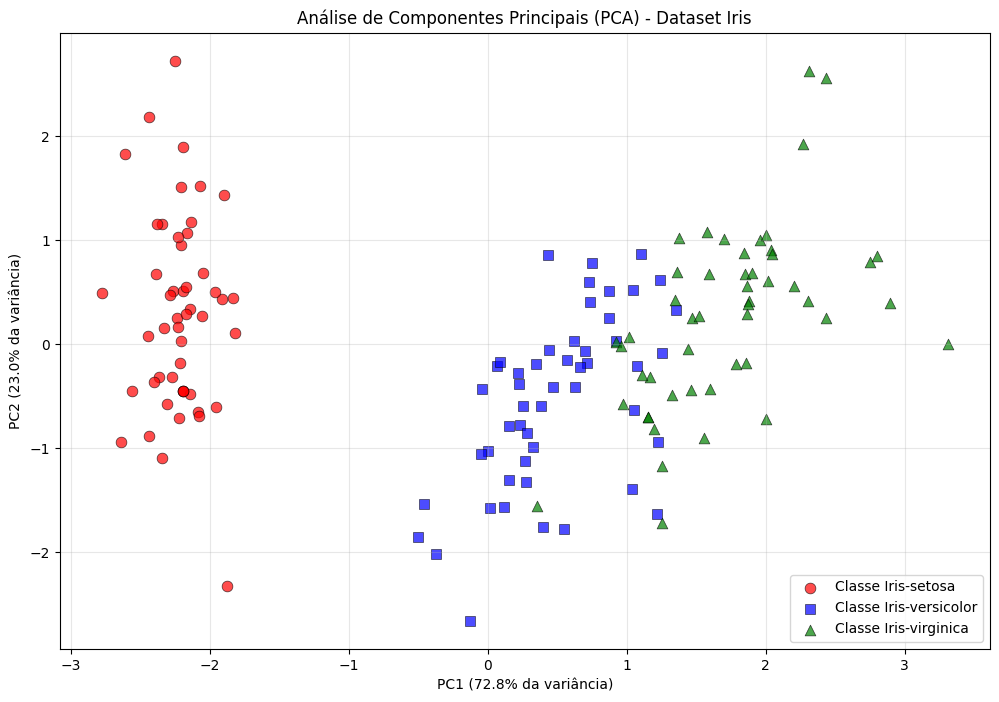

Variância explicada PC1: 72.8%
Variância explicada PC2: 23.0%
Variância explicada total: 95.8%

Componentes Principais:
                   PC1       PC2
sepal length  0.522372  0.372318
sepal width  -0.263355  0.925556
petal length  0.581254  0.021095
petal width   0.565611  0.065416


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green']
markers = ['o', 's', '^']

for i, species in enumerate(df['target'].unique()):
    mask = df['target'] == species
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
            c=colors[i], marker=markers[i], label=f'Classe {species}',
            alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} da variância)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} da variância)')
plt.title('Análise de Componentes Principais (PCA) - Dataset Iris')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Variância explicada PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"Variância explicada PC2: {pca.explained_variance_ratio_[1]:.1%}")
print(f"Variância explicada total: {sum(pca.explained_variance_ratio_):.1%}")

print("\nComponentes Principais:")
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=features
)
print(components_df)


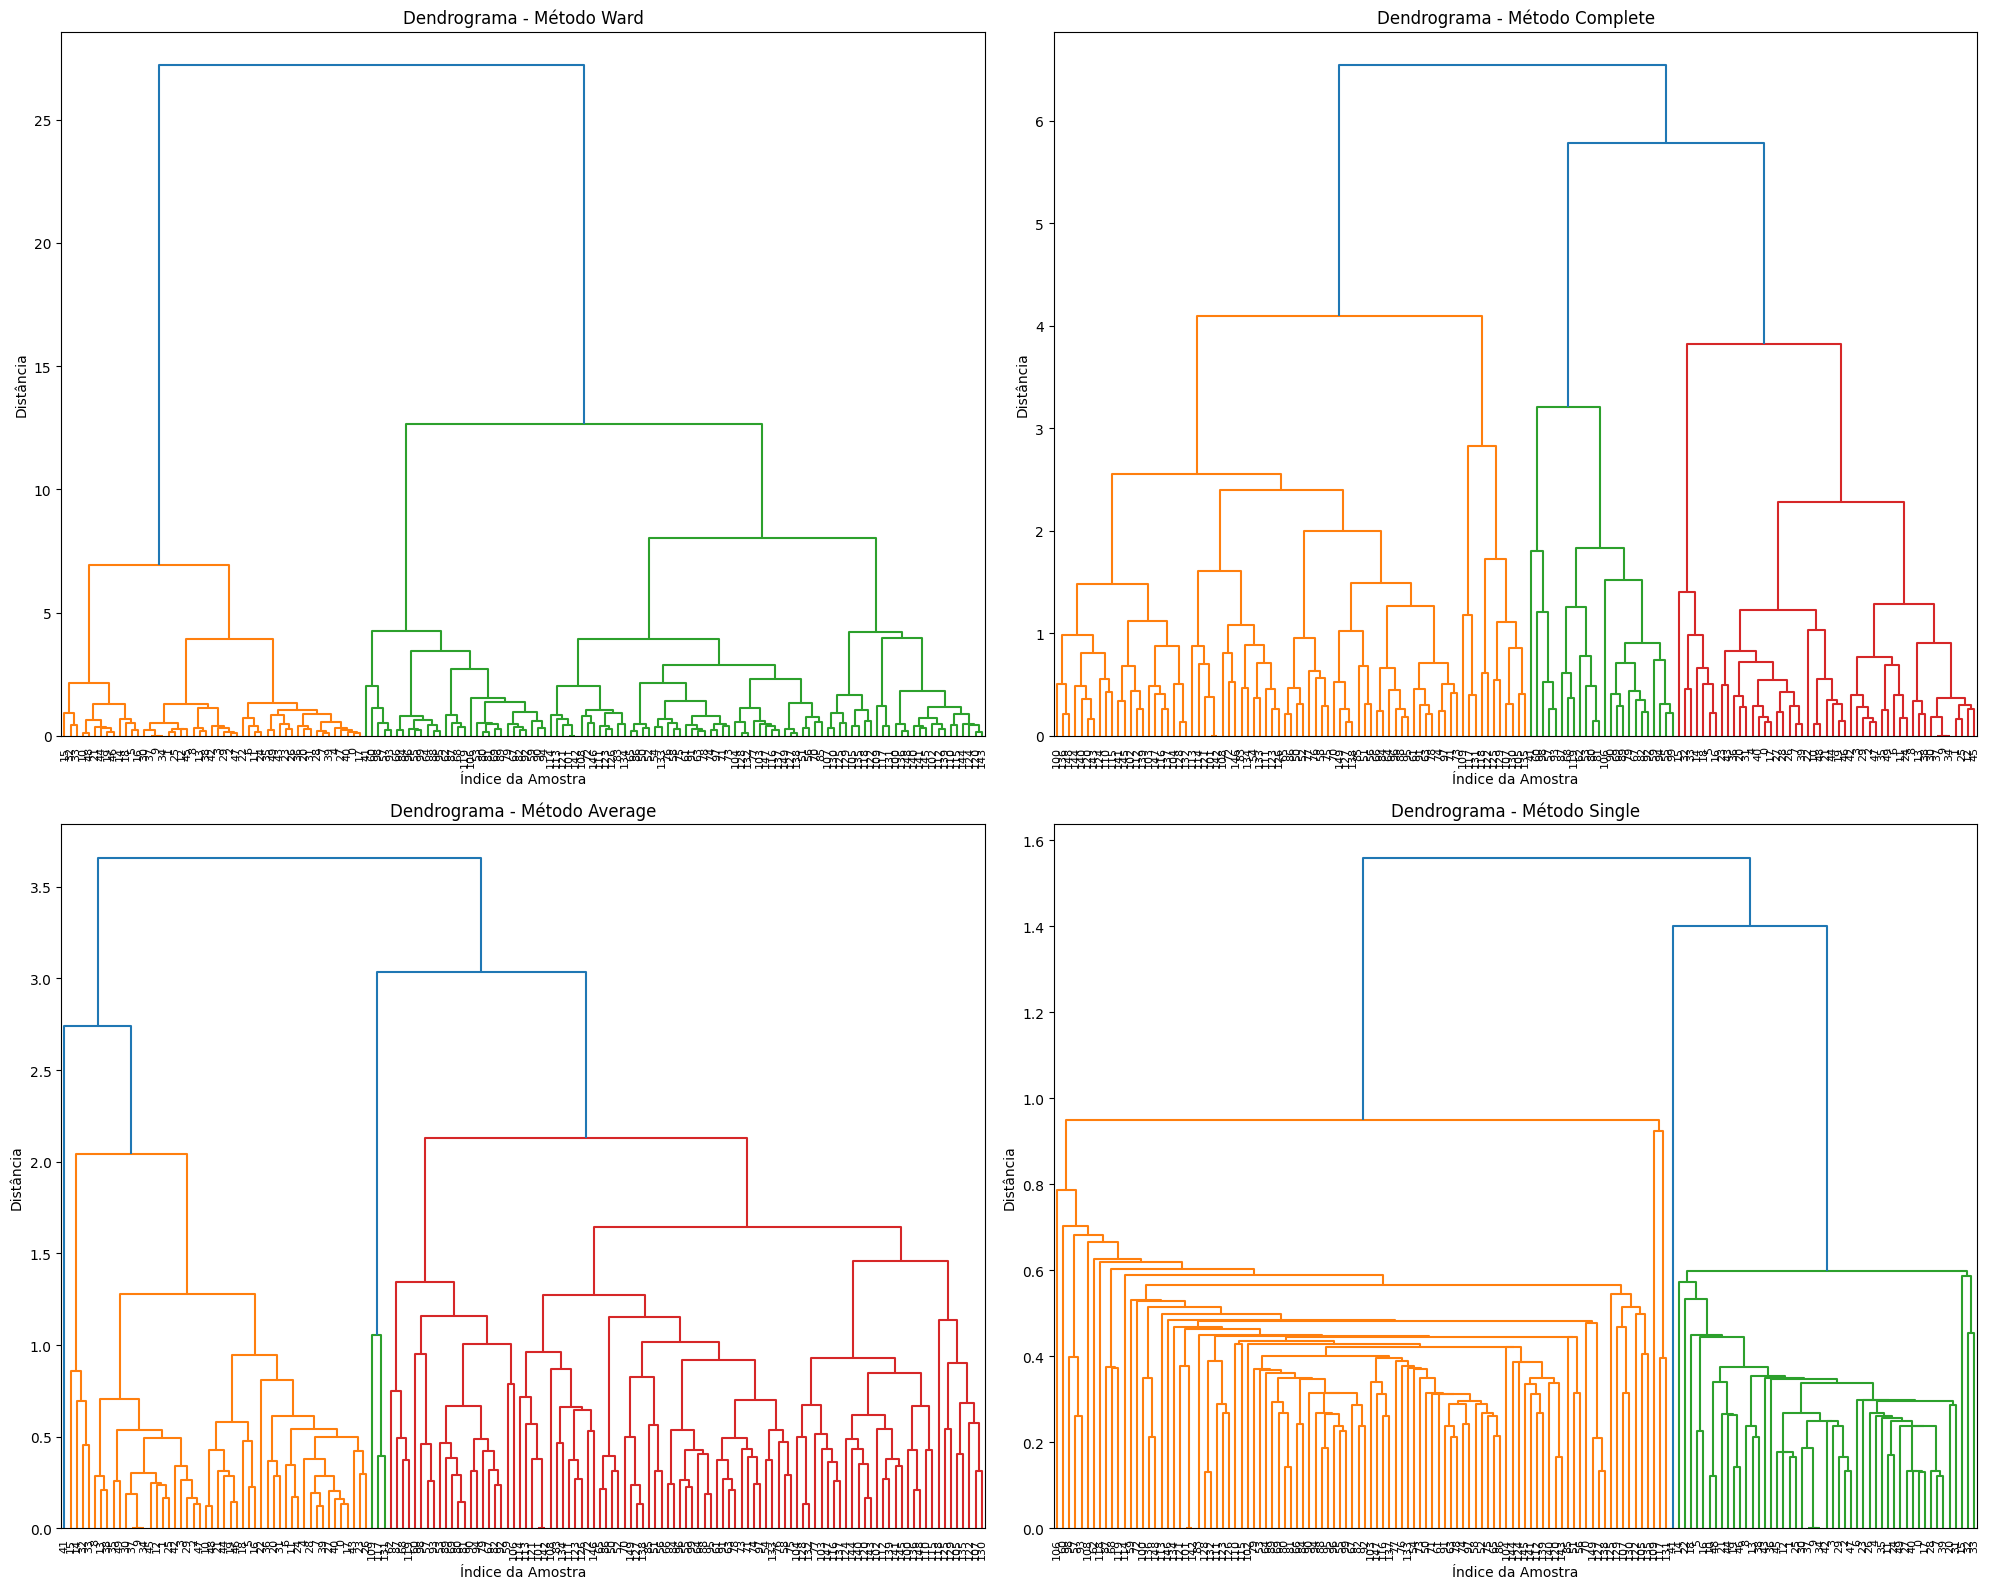


Clustering Hierárquico - Silhouette Scores para todos os métodos:

Método: ward
k=2: Silhouette Score = 0.575
k=3: Silhouette Score = 0.446
k=4: Silhouette Score = 0.399
k=5: Silhouette Score = 0.355
k=6: Silhouette Score = 0.337

Método: complete
k=2: Silhouette Score = 0.440
k=3: Silhouette Score = 0.449
k=4: Silhouette Score = 0.410
k=5: Silhouette Score = 0.354
k=6: Silhouette Score = 0.312

Método: average
k=2: Silhouette Score = 0.580
k=3: Silhouette Score = 0.479
k=4: Silhouette Score = 0.406
k=5: Silhouette Score = 0.374
k=6: Silhouette Score = 0.326

Método: single
k=2: Silhouette Score = 0.580
k=3: Silhouette Score = 0.503
k=4: Silhouette Score = 0.406
k=5: Silhouette Score = 0.341
k=6: Silhouette Score = 0.201


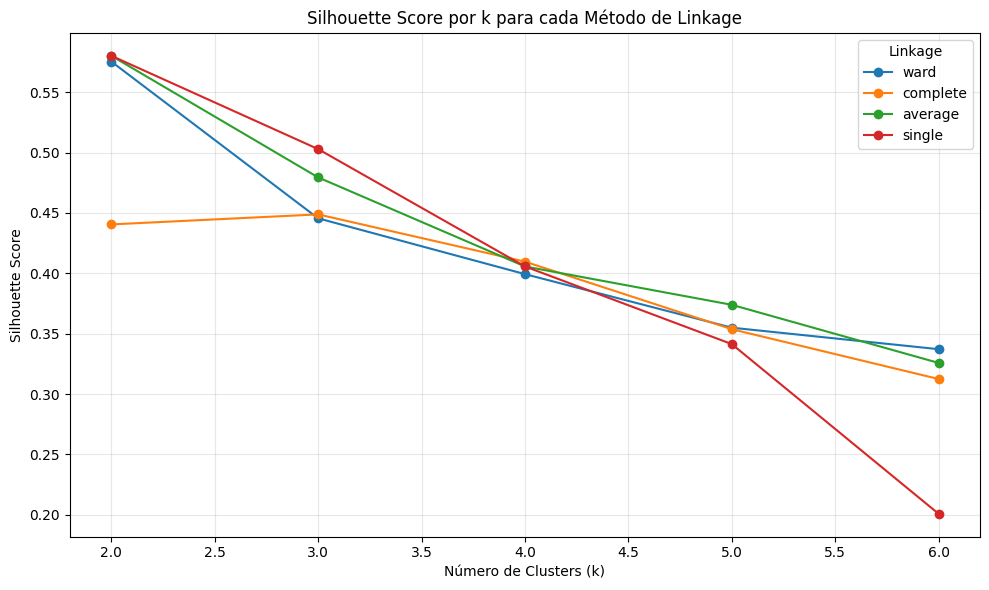

In [ ]:
distances = pdist(X_scaled, metric='euclidean')

linkage_methods = ['ward', 'complete', 'average', 'single']
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

all_scores = {}

for i, method in enumerate(linkage_methods):
    Z = linkage(distances, method=method)
    ax = axes[i]
    dendrogram(Z, ax=ax, leaf_rotation=90, leaf_font_size=8)
    ax.set_title(f'Dendrograma - Método {method.capitalize()}')
    ax.set_xlabel('Índice da Amostra')
    ax.set_ylabel('Distância')

if method == 'simple':
    heights = Z[:, 2]
    threshold_3_clusters = heights[-(3-1)]
    ax.axhline(y=threshold_3_clusters, color='red', linestyle='--',
                alpha=0.7, label='Corte para 3 clusters')
    ax.legend()

plt.tight_layout()
plt.savefig('dendrogramas_comparacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClustering Hierárquico - Silhouette Scores para todos os métodos:")
k_range = range(2, 7)
for method in linkage_methods:
    print(f"\nMétodo: {method}")
    all_scores[method] = []
    for k in k_range:
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = model.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        all_scores[method].append(score)
        print(f"k={k}: Silhouette Score = {score:.3f}")

plt.figure(figsize=(10, 6))
for method in linkage_methods:
    plt.plot(k_range, all_scores[method], marker='o', label=method)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por k para cada Método de Linkage')
plt.legend(title='Linkage')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

K=2: Inércia=223.73, Silhouette=0.580
K=3: Inércia=140.97, Silhouette=0.459
K=4: Inércia=114.62, Silhouette=0.385
K=5: Inércia=91.30, Silhouette=0.347
K=6: Inércia=81.76, Silhouette=0.341
K=7: Inércia=71.32, Silhouette=0.329
K=8: Inércia=62.65, Silhouette=0.340
K=9: Inércia=55.26, Silhouette=0.343
K=10: Inércia=50.62, Silhouette=0.340


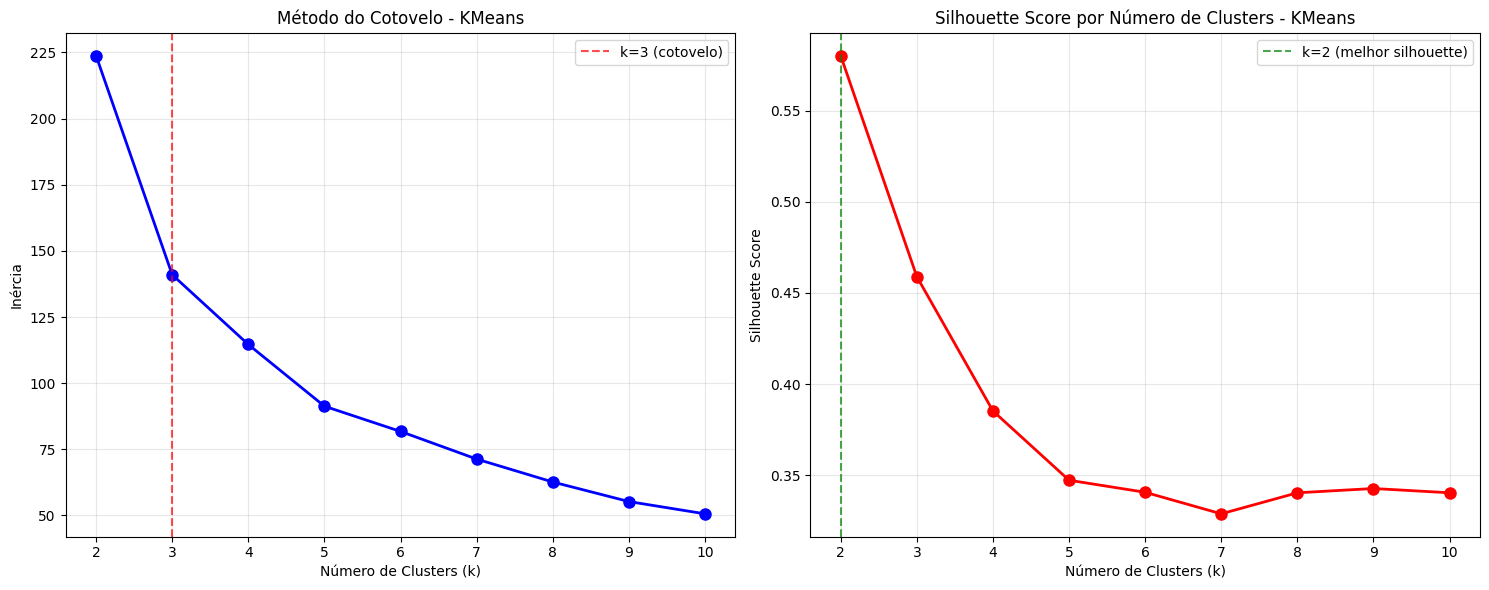

In [ ]:
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)
    print(f"K={k}: Inércia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inércia')
ax1.set_title('Método do Cotovelo - KMeans')
ax1.grid(True, alpha=0.3)
# Destacar k=3
ax1.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3 (cotovelo)')
ax1.legend()

ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score por Número de Clusters - KMeans')
ax2.grid(True, alpha=0.3)


best_k_silhouette = K_range[np.argmax(silhouette_scores)]
ax2.axvline(x=best_k_silhouette, color='green', linestyle='--', alpha=0.7,
        label=f'k={best_k_silhouette} (melhor silhouette)')
ax2.legend()

plt.tight_layout()
plt.savefig('elbow_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


Resultados KMeans:
 - k=2 | Silhouette: 0.5802 | ARI: 0.5681
 - k=3 | Silhouette: 0.4787 | ARI: 0.4290

Resultados Hierárquico:
 - k=2 | Silhouette: 0.5754 | ARI: 0.5438
 - k=3 | Silhouette: 0.4455 | ARI: 0.6153


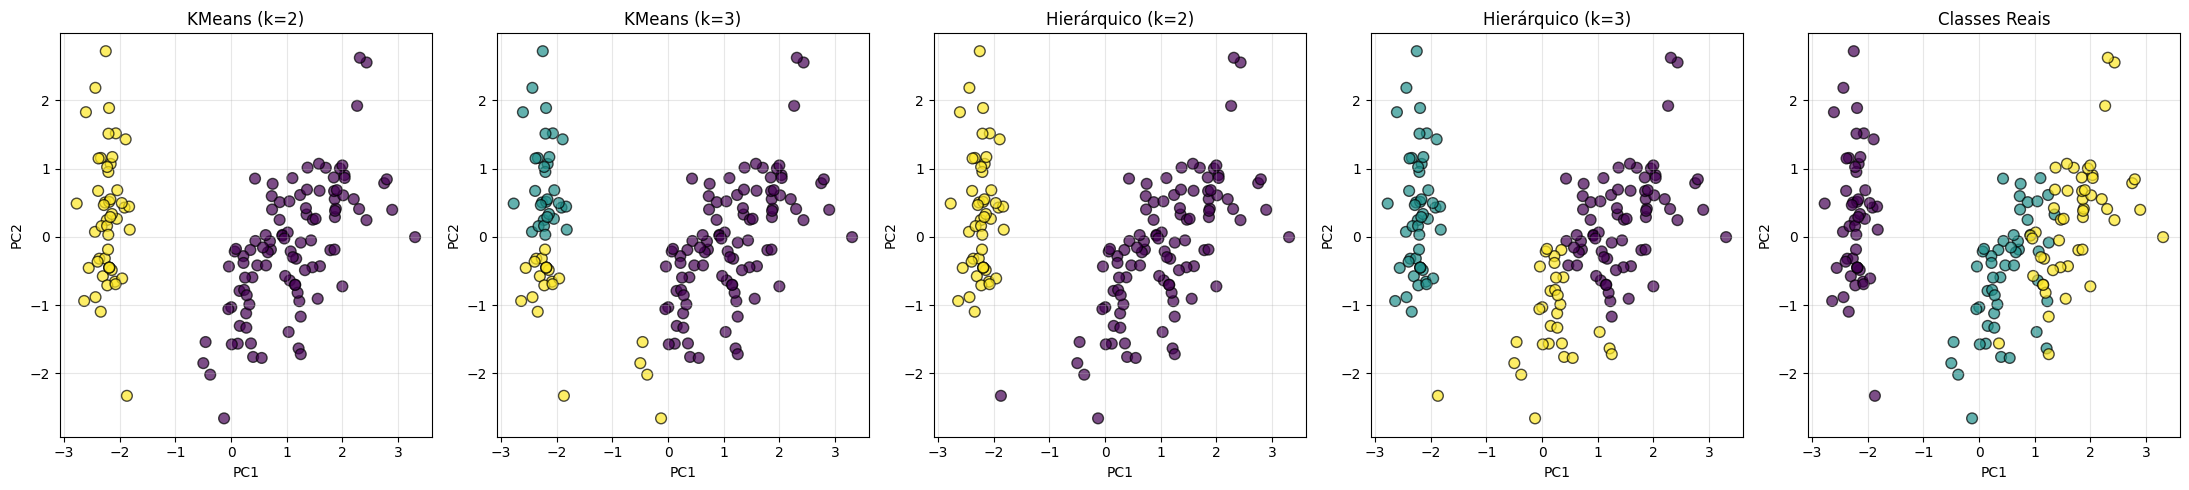

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

kmeans_k2 = KMeans(n_clusters=2, random_state=42)
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
labels_kmeans_k2 = kmeans_k2.fit_predict(X_scaled)
labels_kmeans_k3 = kmeans_k3.fit_predict(X_scaled)

hier_k2 = AgglomerativeClustering(n_clusters=2, linkage='ward')
hier_k3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hier_k2 = hier_k2.fit_predict(X_scaled)
labels_hier_k3 = hier_k3.fit_predict(X_scaled)

sil_k2 = silhouette_score(X_scaled, labels_kmeans_k2)
sil_k3 = silhouette_score(X_scaled, labels_kmeans_k3)
sil_h2 = silhouette_score(X_scaled, labels_hier_k2)
sil_h3 = silhouette_score(X_scaled, labels_hier_k3)

ari_k2 = adjusted_rand_score(y_aux, labels_kmeans_k2)
ari_k3 = adjusted_rand_score(y_aux, labels_kmeans_k3)
ari_h2 = adjusted_rand_score(y_aux, labels_hier_k2)
ari_h3 = adjusted_rand_score(y_aux, labels_hier_k3)

print("Resultados KMeans:")
print(f" - k=2 | Silhouette: {sil_k2:.4f} | ARI: {ari_k2:.4f}")
print(f" - k=3 | Silhouette: {sil_k3:.4f} | ARI: {ari_k3:.4f}")

print("\nResultados Hierárquico:")
print(f" - k=2 | Silhouette: {sil_h2:.4f} | ARI: {ari_h2:.4f}")
print(f" - k=3 | Silhouette: {sil_h3:.4f} | ARI: {ari_h3:.4f}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

if y_aux.dtype == 'object':
    y_encoded = y_aux.map({label: idx for idx, label in enumerate(np.unique(y_aux))})
else:
    y_encoded = y_aux

labels_list = [labels_kmeans_k2, labels_kmeans_k3, labels_hier_k2, labels_hier_k3, y_encoded]
titles = ['KMeans (k=2)', 'KMeans (k=3)', 'Hierárquico (k=2)', 'Hierárquico (k=3)', 'Classes Reais']

fig, axes = plt.subplots(1, 5, figsize=(22, 5))

for ax, labels, title in zip(axes, labels_list, titles):
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=60, alpha=0.7, edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Resultados com 2 features (petal length, petal width):

KMeans:
 - k=2 | Silhouette: 0.7432 | ARI: 0.5681
 - k=3 | Silhouette: 0.6736 | ARI: 0.8857

Hierárquico:
 - k=2 | Silhouette: 0.7432 | ARI: 0.5681
 - k=3 | Silhouette: 0.6095 | ARI: 0.6357


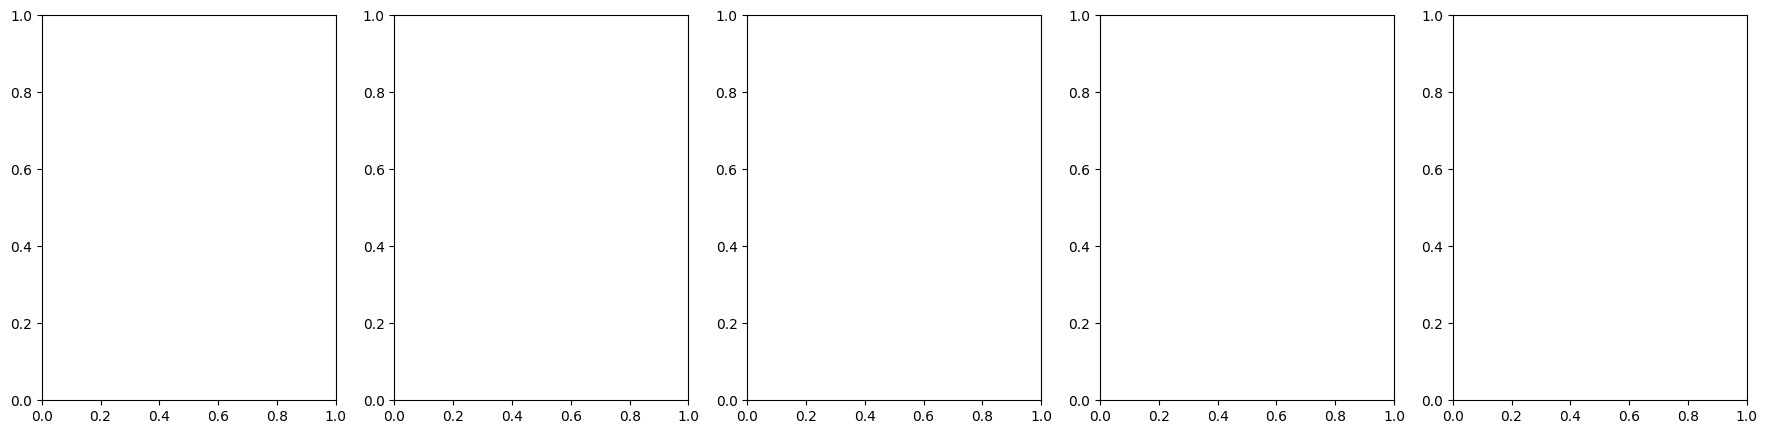

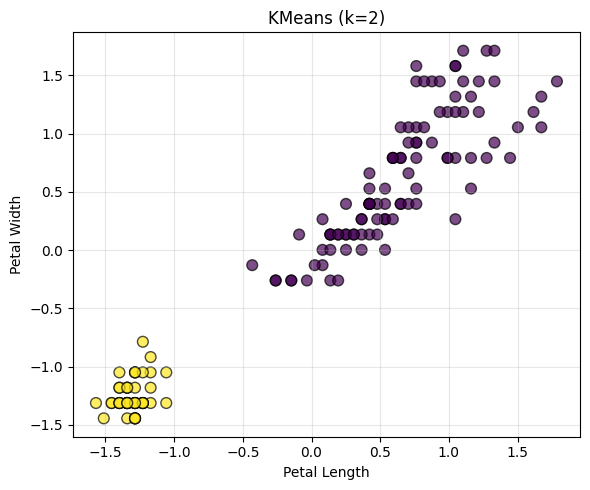

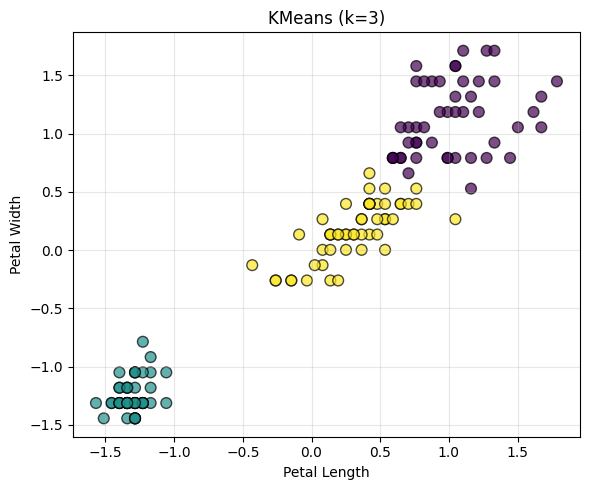

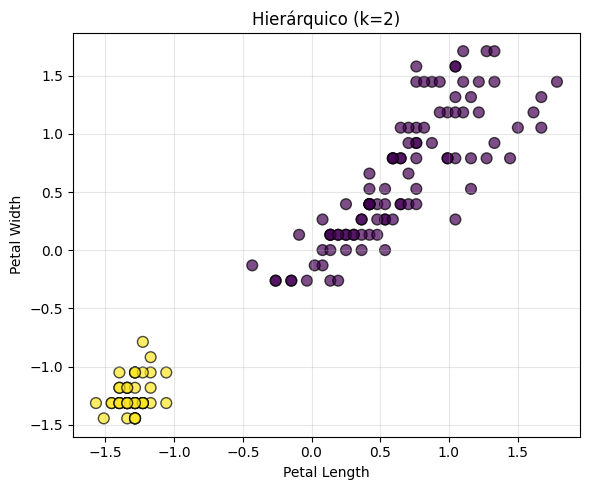

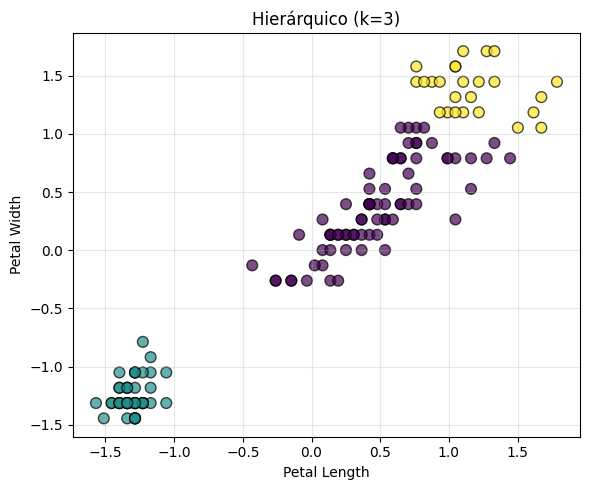

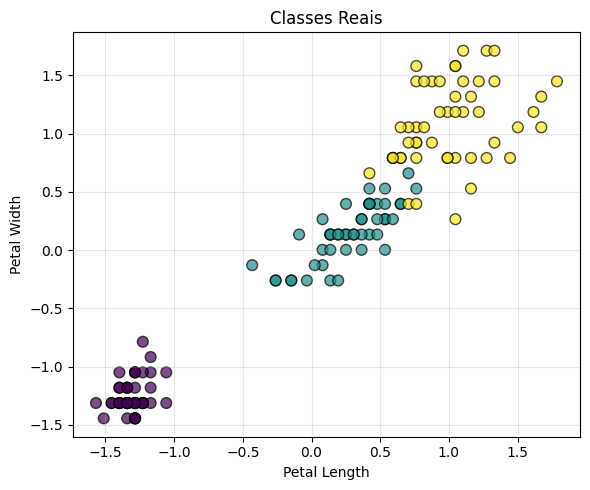

In [61]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np

X_2feat = X[['petal length', 'petal width']]
X_2_scaled = scaler.fit_transform(X_2feat)

kmeans_2_k2 = KMeans(n_clusters=2, random_state=42)
kmeans_2_k3 = KMeans(n_clusters=3, random_state=42)
labels_kmeans_2_k2 = kmeans_2_k2.fit_predict(X_2_scaled)
labels_kmeans_2_k3 = kmeans_2_k3.fit_predict(X_2_scaled)

hier_2_k2 = AgglomerativeClustering(n_clusters=2, linkage='ward')
hier_2_k3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hier_2_k2 = hier_2_k2.fit_predict(X_2_scaled)
labels_hier_2_k3 = hier_2_k3.fit_predict(X_2_scaled)

sil_kmeans_2_k2 = silhouette_score(X_2_scaled, labels_kmeans_2_k2)
sil_kmeans_2_k3 = silhouette_score(X_2_scaled, labels_kmeans_2_k3)
ari_kmeans_2_k2 = adjusted_rand_score(y_aux, labels_kmeans_2_k2)
ari_kmeans_2_k3 = adjusted_rand_score(y_aux, labels_kmeans_2_k3)

sil_hier_2_k2 = silhouette_score(X_2_scaled, labels_hier_2_k2)
sil_hier_2_k3 = silhouette_score(X_2_scaled, labels_hier_2_k3)
ari_hier_2_k2 = adjusted_rand_score(y_aux, labels_hier_2_k2)
ari_hier_2_k3 = adjusted_rand_score(y_aux, labels_hier_2_k3)

print("Resultados com 2 features (petal length, petal width):")
print("\nKMeans:")
print(f" - k=2 | Silhouette: {sil_kmeans_2_k2:.4f} | ARI: {ari_kmeans_2_k2:.4f}")
print(f" - k=3 | Silhouette: {sil_kmeans_2_k3:.4f} | ARI: {ari_kmeans_2_k3:.4f}")
print("\nHierárquico:")
print(f" - k=2 | Silhouette: {sil_hier_2_k2:.4f} | ARI: {ari_hier_2_k2:.4f}")
print(f" - k=3 | Silhouette: {sil_hier_2_k3:.4f} | ARI: {ari_hier_2_k3:.4f}")

labels_list = [
    labels_kmeans_2_k2, labels_kmeans_2_k3,
    labels_hier_2_k2, labels_hier_2_k3,
    y_encoded
]
titles = [
    'KMeans (k=2)', 'KMeans (k=3)',
    'Hierárquico (k=2)', 'Hierárquico (k=3)',
    'Classes Reais'
]

fig, axes = plt.subplots(1, 5, figsize=(22, 5))
# Plotar os resultados de clustering com 2 features separado sem agrumar
for i, (labels, title) in enumerate(zip(labels_list, titles)):
    fig, ax = plt.subplots(figsize=(6, 5))
    
    scatter = ax.scatter(
        X_2_scaled[:, 0], X_2_scaled[:, 1],
        c=labels, cmap='viridis', s=60, alpha=0.7, edgecolor='k'
    )
    
    ax.set_title(title)
    ax.set_xlabel('Petal Length')
    ax.set_ylabel('Petal Width')
    ax.grid(True, alpha=0.3)

    # Gerar nome de arquivo baseado no índice e título
    filename = f"{title.lower().replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

